## Library Imports

In [1]:
from OCR import OCR_Model
from PIL import Image, ImageDraw, ImageFont
from pdf2image import convert_from_path
from matplotlib import pyplot as plt
from dotenv import load_dotenv
from PIL import Image
from groq import Groq
import json
import os

load_dotenv()

api_key = os.getenv("GROQ_API_KEY")
client = Groq(api_key=api_key)

## Extracting the OCR from images/PDFs

In [2]:
doc_path = "MH_LandRecords_PDFs/satbara.pdf"

if doc_path.endswith('.pdf'):
    # Convert PDF to images
    image = convert_from_path(doc_path, dpi=300)[0]
elif doc_path.endswith('.png') or doc_path.endswith('.jpg'):
    image = Image.open(doc_path).convert('RGB')

ocr = OCR_Model()

predictions = ocr.predict(images = [image])

Recognizing Text: 100%|██████████| 130/130 [02:43<00:00,  1.25s/it]


## Plotting OCR results

Image saved to outputs/images/satbara.png


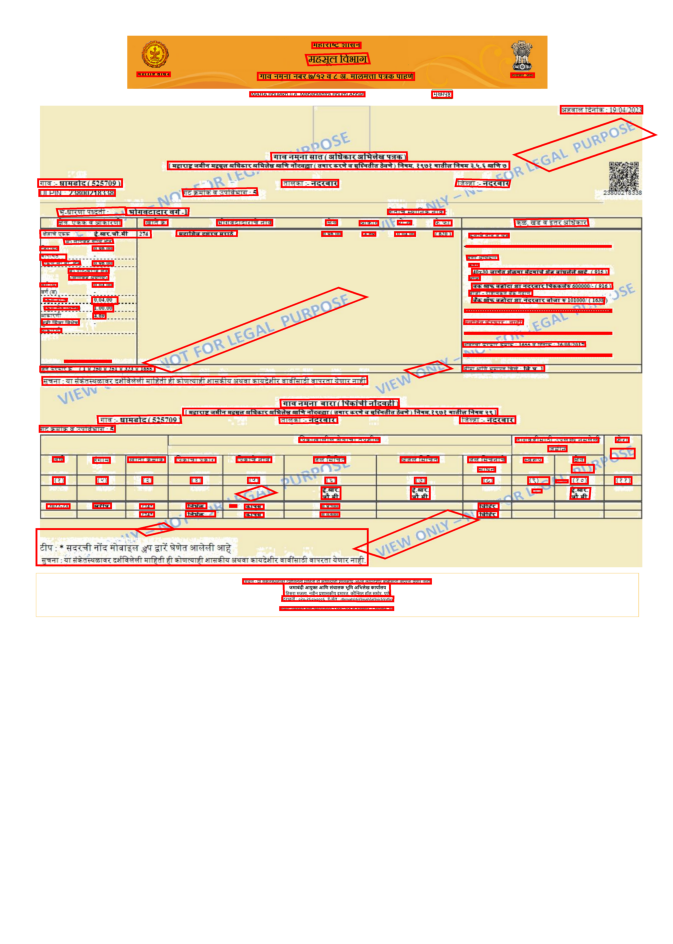

In [3]:
ocr.plot_prediction( image=image, predictions=predictions, show=True, save_path="outputs/images/satbara.png")

## Extracting the needed information using LLM

In [4]:
All_text = []
for line in predictions[0].text_lines:
    All_text.append(line.text)

In [ ]:
def extract_fields_from_ocr(all_text_lines):
    joined_text = "\n".join(all_text_lines)

    prompt = f"""
        You are a structured data extractor for Marathi/Hindi land record OCR text.

        Given the OCR text of a legal land document, extract the following fields **precisely**:

        - "अहवाल दिनांक" → from a line like "अहवाल दिनांक : DD/MM/YYYY"
        - "गाव" → word after गाव: (may be in brackets or followed by a number)
        - "तालुका" → word after तालुका :
        - "जिल्हा" → word after जिल्हा :
        - "ULPIN" or "PU-ID" → numerical code following "ULPIN" or "PU-ID"
        - "Owner Name" → all person names in Marathi/Hindi script that are **not** struck-through (i.e., ignore names with `<del>...</del>`), and not phrases like "हे आर.चौ.मी"
        - "प्रलंबित फ़ेरफ़ार" -> नाही.

        ### Rules for Owner Names:
        - Must be a **human name** (e.g., दिपक वावुलाल गोयकर)
        - Ignore any name with `<del>`, or anything that does not resemble a person
        - Return multiple names as a **list**

        ### Output Format:
        Respond with **only** the following JSON object (no extra explanation):

        ```json
        {{
        "अहवाल दिनांक": "DD/MM/YYYY",
        "गाव": "Village Name",
        "तालुका": "Taluka Name",
        "जिल्हा": "District Name",
        "ULPIN/PU-ID": "Number",
        "Owner Name": ["Name 1", "Name 2"]
        "प्रलंबित फ़ेरफ़ार" : 
        }}
        ```
        \"\"\"{joined_text}\"\"\"
    """ 

    chat_completion = client.chat.completions.create(
        model="llama3-8b-8192", 
        messages=[
            {"role": "system", "content": "You extract structured data from OCR of Marathi legal documents."},
            {"role": "user", "content": prompt}
        ],
        temperature=0
    )

    return chat_completion.choices[0].message.content

In [6]:
info = extract_fields_from_ocr(All_text)
print(info)

{
"अहवाल दिनांक": "19/04/2023",
"गाव": "धामडोद (525709 )",
"तालुका": "नंदुरबार",
"जिल्हा": "नंदुरबार",
"ULPIN/PU-ID": "23800218338",
"Owner Name": ["सदाशिव दशरथ मराठे"],
"प्रलंबित फ़ेरफ़ार": "नाही"
}


## Converting into JSON

In [ ]:
parsed = json.loads(info)
parsed

{'अहवाल दिनांक': '19/04/2023',
 'गाव': 'धामडोद (525709 )',
 'तालुका': 'नंदुरबार',
 'जिल्हा': 'नंदुरबार',
 'ULPIN/PU-ID': '23800218338',
 'Owner Name': ['सदाशिव दशरथ मराठे'],
 'प्रलंबित फ़ेरफ़ार': 'नाही'}